In [ ]:
!git clone https://github.com/Mike030668/Project_glass.git -q
!pip install backtesting -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# imports

In [ ]:
import sys
dir_glass = '/content/Project_glass'
sys.path.append(dir_glass)

# модули и функции проекта glass
from prepare_data.constants import GLASS_COLS, FUTURE, MAIN_COLS, DEPTH, PREDICT_LAG, BATCH_SIZE, MAKE_LOG_VOL
from prepare_data.const_predprice import  TARGET_COLS, BASE_COLS, MAKE_LOG_TARGET
from prepare_data.utils import future_sequence, split_sequence, clean_dataset
from scripts.bots import cond_long, cond_short, long_Short
from scripts.robotest import prepare_data, making_signals
from scripts.stratagy import Long_Strategy, Short_Strategy, Long_n_Short_Strategy

from backtesting import Backtest # Библиотеки backtesting
import tensorflow as tf  # библиотека машинного обучения
import pandas as pd # библиотека пандас
import numpy as np # библиотека нампи
import joblib
from tqdm.notebook import tqdm   # отрисовка прохождения цикла
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


## Готовим производные данных

In [ ]:
all_data = pd.read_csv(dir_glass + "/stock_data/BTCUSDT_1 _min.csv",
                       index_col=0, parse_dates=True )
print(f'Размер данных {all_data.shape}')

# колонки для тренировочной выборки сетки тренда
TREND_PRED_COLS = MAIN_COLS + GLASS_COLS

# колонки для тренировочной выборки сетки цены
PRICE_PRED_COLS = BASE_COLS + GLASS_COLS

# N колонки где начинается стакан
GLASS = len(GLASS_COLS)


# скейлеры для сетки тренда
x_trend_main_scr = joblib.load(dir_glass + "/predtrend/x_main_scailer.save")
x_trend_glass_scr = joblib.load("/content/Project_glass/predtrend/x_glass_scailer.save")
trend_scalers = [x_trend_main_scr, x_trend_glass_scr]
# скейлеры для сетки цены
x_price_main_scr = joblib.load(dir_glass + "/predprice/x_main_scailer.save")
x_price_glass_scr = joblib.load(dir_glass + "/predprice/x_glass_scailer.save")
y_price_scr = joblib.load(dir_glass + "/predprice/y_scailer.save")
price_scalers = [x_price_main_scr, x_price_glass_scr, y_price_scr]

Размер данных (8317, 54)


# Nets

In [ ]:
# сетки
trend_model =  tf.keras.models.load_model(dir_glass + "/predtrend/model_gen")
price_model =  tf.keras.models.load_model(dir_glass + "/predprice/model_gen")


# Пример теста 3-го бота по ТЗ

- Вход лонг:

      Покупаем когда текущая позиция 0 (ничего не куплено) И
      Сетка 1 показывает все пять предсказаний выше текущей цены И
      Предсказания 2, 3,4 выше текущей цены на более чем 0, 05%


- Выход из лонга:

      Продаем позицию если
      Сетка 1 показывает 1е и 3е предсказания ниже текущей цены

      После выхода проверяем условие на вход в позицию. (Т.к. на одной итерации могут сложиться условия и для выхода из лонга и для входа в шорт сразу)


- Вход шорт:

      Продаем когда текущая позиция 0 (ничего не куплено) И :
      Сетка 1 показывает все пять предсказаний ниже текущей цены И
      Предсказания 2, 3,4 ниже текущей цены на более чем 0, 05%


- Выход из шорта:

      Продаем позицию если
      Сетка 1 показывает 1е и 3е предсказания выше текущей цены

      После выхода проверяем условие на вход в позицию.
__________________________________

Используется:
- tresh_hold для указания порога цены
- lg_id_pr_up_tresh, lg_id_pr_lw_treshб sh_id_pr_up_tresh,sh_id_pr_lw_tresh индексы к которым применяется трешхолд

__________________________________

**Добавлено приземление цены**

корректируем ли цену сравнивая прошлое и текцщее 2 варианта:
- `pred_price` по разнице предскаханий с шага t и t-1
- `cur_price` по разнице предскахания с текущей;

In [7]:
FUTURE = 3000

# длина взгляда назад
BACK = DEPTH + PREDICT_LAG
TEST_SIZE = 5000
# данные назад
past_data =  all_data[FUTURE-BACK : FUTURE - PREDICT_LAG].copy()

# тестируемы датафрейм
test_data = all_data[FUTURE-PREDICT_LAG : FUTURE + TEST_SIZE].copy()

# получаем датафрейм с сигналом
df_test_signal = making_signals(past_data,
                                test_data,
                                # функция управления с сигналом по индексам
                                fun_action = long_Short(
                                          action = "mix",      # mix = long_Short
                                          # long индексы [0,1,2,3,4]
                                          lg_id_pr_up = [0,1,2,3,4], # id предсказаний выше текущей цены
                                          lg_id_tr_up = [], # Рост по id
                                          lg_id_pr_lw = [1, 3], # id предсказаний ниже текущей цены
                                          lg_id_tr_lw = [0], # Падение по id
                                          lg_id_pr_up_tresh = [2,3,4],
                                          lg_id_pr_lw_tresh = [],
                                          # short индексы [0,1,2,3,4]
                                          sh_id_pr_up = [0,1,2,3,4], # id предсказаний выше текущей цены
                                          sh_id_tr_up = [], # Рост по id
                                          sh_id_pr_lw = [0, 3], # id предсказаний ниже текущей цены
                                          sh_id_tr_lw = [], # Падение по id
                                          sh_id_pr_up_tresh = [],
                                          sh_id_pr_lw_tresh = [2,3,4],
                                          tresh_hold = 0.05,
                                          # приземляем ли предсказание и как
                                          correct_price = "Aleksei" # False # "Michal" #
                                ),

                                pred_lag = PREDICT_LAG,
                                glass = GLASS,
                                depth = DEPTH,
                                make_log_vol = MAKE_LOG_VOL,
                                make_log_tgt = MAKE_LOG_TARGET,
                                model_price = price_model,
                                model_trend = trend_model,
                                scalers_price = price_scalers,
                                scalers_trend = trend_scalers,
                                features_price = PRICE_PRED_COLS,
                                features_trend = TREND_PRED_COLS,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/5000 [00:00<?, ?step/s]

[-1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0

In [ ]:
#path_file_name = "....."
#df_test_signal.to_csv(path_file_name, sep='\t', encoding='utf-8')

## Совмещенный график предсказаний



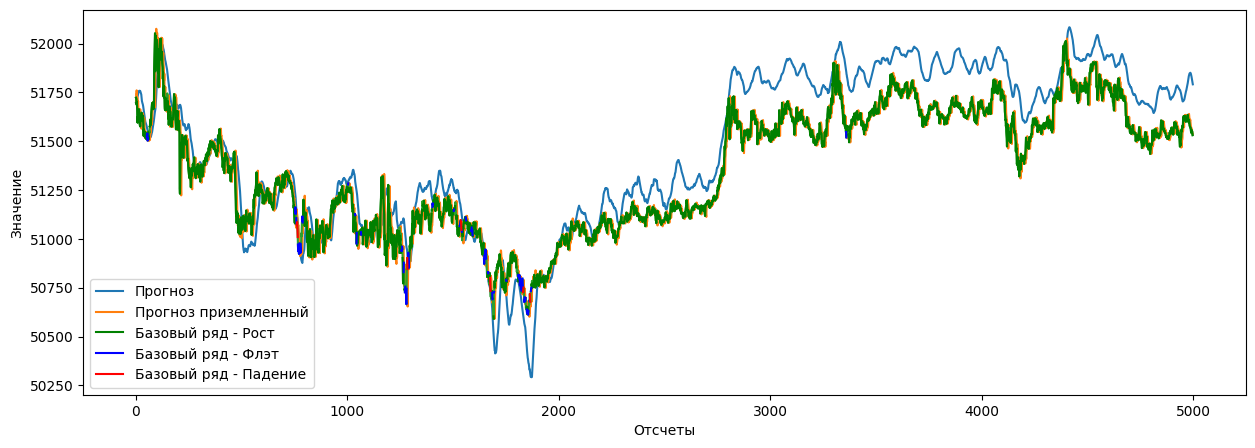

In [12]:
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
y_pred_earth = df_test_signal["pred_earth_price"].astype(float).to_numpy()
y_pred = df_test_signal["pred_price"].astype(float).to_numpy()
y_true = df_test_signal["Close"].to_numpy()

# pred_trend
y_pred_trend = df_test_signal["pred_trend"].astype(int).to_numpy()
down = (y_pred_trend == -1)
flat = (y_pred_trend == 0)
gross = (y_pred_trend == 1)

# смещаем на 1 вперед чтобы совместить педсказания завтра с реальной ценой на завтра
plt.figure(figsize=(15,5))
plt.plot(y_pred, label=f'Прогноз')
plt.plot(y_pred_earth, label=f'Прогноз приземленный')


plt.plot(y_true[1:])
plt.plot(np.where(gross[1:], y_true[1:], None), color="green", label= 'Базовый ряд - Рост')
plt.plot(np.where(flat[1:], y_true[1:], None), color="blue", label= 'Базовый ряд - Флэт')
plt.plot(np.where(down[1:], y_true[1:], None), color="red", label= 'Базовый ряд - Падение')

plt.xlabel('Отсчеты')
plt.ylabel(f'Значение')
plt.legend()
plt.show()



# Backtest

## Short_Strategy

In [9]:
CAPITAL = 100000
COMIS = 0.0002

# Стратегия
bt = Backtest(df_test_signal, Short_Strategy, cash= CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Start                     2024-02-22 19:00:00
End                       2024-02-26 06:27:00
Duration                      3 days 11:27:00
Exposure Time [%]                         0.0
Equity Final [$]                     100000.0
Equity Peak [$]                      100000.0
Return [%]                                0.0
Buy & Hold Return [%]               -0.367739
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

## Long_Strategy

In [10]:
CAPITAL = 100000

# Стратегия Long
bt = Backtest(df_test_signal, Long_Strategy, cash= CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Текущий капитал  100000
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  100149
______________________________________________
Закрытие позиции
Размер позиции 1
Прибыль/убыток (позиции в деньгах 148.7126000000062
Прибыль/убыток позиции в % 0.0029189560324973662
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  100149
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  100011
______________________________________________
Закрытие позиции
Размер позиции 1
Прибыль/убыток (позиции в деньгах -137.57053999999334
Прибыль/убыток позиции в % -0.0027047340926581454
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  100011
_____________________

Start                     2024-02-22 19:00:00
End                       2024-02-26 06:27:00
Duration                      3 days 11:27:00
Exposure Time [%]                       80.26
Equity Final [$]                 100777.59008
Equity Peak [$]                  101254.49008
Return [%]                            0.77759
Buy & Hold Return [%]               -0.367739
Return (Ann.) [%]                   76.023122
Volatility (Ann.) [%]               14.340615
Sharpe Ratio                         5.301245
Sortino Ratio                       35.194945
Calmar Ratio                       116.446253
Max. Drawdown [%]                    -0.65286
Avg. Drawdown [%]                   -0.099129
Max. Drawdown Duration        0 days 18:06:00
Avg. Drawdown Duration        0 days 01:36:00
# Trades                                    3
Win Rate [%]                        66.666667
Best Trade [%]                       1.509843
Worst Trade [%]                     -0.270473
Avg. Trade [%]                    

## Long_n_Short_Strategy

In [11]:
CAPITAL = 100000

# Стратегия Long_Short
bt = Backtest(df_test_signal, Long_n_Short_Strategy, cash= CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Текущий капитал  100000
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  100149
______________________________________________
Закрытие позиции LONG
Размер позиции 1
Прибыль/убыток (позиции в деньгах 148.7126000000062
Прибыль/убыток позиции в % 0.0029189560324973662
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  100149
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  100011
______________________________________________
Закрытие позиции LONG
Размер позиции 1
Прибыль/убыток (позиции в деньгах -137.57053999999334
Прибыль/убыток позиции в % -0.0027047340926581454
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  100011
___________

Start                     2024-02-22 19:00:00
End                       2024-02-26 06:27:00
Duration                      3 days 11:27:00
Exposure Time [%]                       80.26
Equity Final [$]                 100777.59008
Equity Peak [$]                  101254.49008
Return [%]                            0.77759
Buy & Hold Return [%]               -0.367739
Return (Ann.) [%]                   76.023122
Volatility (Ann.) [%]               14.340615
Sharpe Ratio                         5.301245
Sortino Ratio                       35.194945
Calmar Ratio                       116.446253
Max. Drawdown [%]                    -0.65286
Avg. Drawdown [%]                   -0.099129
Max. Drawdown Duration        0 days 18:06:00
Avg. Drawdown Duration        0 days 01:36:00
# Trades                                    3
Win Rate [%]                        66.666667
Best Trade [%]                       1.509843
Worst Trade [%]                     -0.270473
Avg. Trade [%]                    